<a href="https://colab.research.google.com/github/wonmadeit/LEEGAWON/blob/main/5_Building_a_neural_network_using_PyTorch_on_a_toy_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Toy dataset으로 신경망 모델 작성 (PyTorch 활용)

In [24]:
import torch
x = [[1,2],[3,4],[5,6],[7,8]]
y = [[3],[7],[11],[15]]

In [25]:
X = torch.tensor(x).float()
Y = torch.tensor(y).float()

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
X = X.to(device)
Y = Y.to(device)

In [28]:
import torch.nn as nn

- `nn.Module`을 상속받아 `__init__` 함수를 override하여 layer 정의

- `nn.Linear(2, 8)`의 의미
  - 이전 레이어의 노드 개수 : 2개, 다음 레이어의 노드 개수 : 8개, bias 존재하는 fully-connected layer (존재하지 않는 레이어 만들려면 `argument bias=False` 추가)

- PyTorch는 forward pass를 위해 `nn.Module`의 `forward` 함수를 override (재정의)하여 사용


- (직접 해보기) ReLU 대신에 다른 활성 함수 사용해볼 것

In [29]:
class MyNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_to_hidden_layer = nn.Linear(2,8)         #이전레이어 노드 수 2개, 다음레이어 노드수 8개 연결 connected by fully connect(전부다연결)
        self.hidden_layer_activation = nn.LeakyReLU()       #
        self.hidden_to_output_layer = nn.Linear(8,1)        #
    def forward(self, x):                                   #tensor를 입력값으로 받아 어떤경로로 흘러가게 할지 지정
        x = self.input_to_hidden_layer(x)
        x = self.hidden_layer_activation(x)
        x = self.hidden_to_output_layer(x)
        return x

- 정의한 신경망 클래스의 instance를 생성할 때 weight 같은 parameter가 random하게 초기화 됨
  - 항상 똑같이 초기화 되기를 원한다면, `torch.manual_seed(0)` 함수 사용

In [30]:
mynet = MyNeuralNet().to(device)      #to함수 : cuda 드라이버 gpu로 업로드, mynet이 참조, 순전파 준비끝

# 새 섹션

In [31]:
mynet.input_to_hidden_layer.weight # input_to_hidden_layer의 가중치 확인
for par in mynet.parameters(): # 모든 layer의 parameter 확인
    print(par)

Parameter containing:
tensor([[ 0.2756,  0.3629],
        [-0.6945, -0.5740],
        [-0.4877, -0.3064],
        [ 0.6433,  0.2381],
        [-0.3653, -0.0401],
        [ 0.2546,  0.4638],
        [ 0.6500, -0.6721],
        [-0.1346,  0.0975]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.7036, -0.6545,  0.6620,  0.2308,  0.5505, -0.4860, -0.5225, -0.1231],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.2134,  0.1894,  0.0648,  0.1739, -0.0697,  0.1195, -0.1683,  0.3190]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0127], device='cuda:0', requires_grad=True)


- 다른 손실함수도 사용해 볼 것
  - CrossEntropyLoss
  - BCELoss 등

In [32]:
loss_func = nn.MSELoss()
# loss_func = nn.BCSLoss()

In [33]:
_Y = mynet(X)
loss_value = loss_func(_Y,Y)
print(loss_value) # 이 값은 random하게 생성된 parameter 초기값 때문에 아래 결과와 다를 수 있음

tensor(89.6419, device='cuda:0', grad_fn=<MseLossBackward0>)


- 다른 optimizer도 사용해 볼 것
  - Adam
  - RMSProp 등

In [34]:
from torch.optim import SGD
opt = SGD(mynet.parameters(), lr = 0.001)

- `detach()` : Graph에서 분리한 새로운 Tensor를 Return
  - PyTorch는 Tensor에서 이루어진 모든 연산을 추적해서 기록해 놓음(Graph)
    - 이 연산 기록으로부터 미분이 계산되고, 역전파가 이루어짐
    - `detach()`는 이 연산 기록으로부터 분리한 Tensor를 반환하는 Method

- `cpu()` : GPU메모리에 올려져 있는 Tensor를 CPU 메모리로 복사

- `numpy()` : Tensor를 Numpy로 변환하여 반환
  - 저장공간을 공유하기 때문에 하나를 변경하면 다른 하나를 변경함
  - CPU메모리에 올려져 있는 Tensor만 `numpy()` method를 사용할 수 있음

In [35]:
# 필수!! 모델구조
loss_history = []
for _ in range(50):   #epoch = 50
    opt.zero_grad() # gradient를 0으로 초기화 - 매 epoch 시작 시 혹은 매 epoch 끝날 때
    loss_value = loss_func(mynet(X),Y) # 추정값과 정답 label 사이의 loss 계산, mynet = 신경망
    loss_value.backward() # back-propagation : 역전파 단계, 현 parameter들의 loss에 대한 변화도(미분값) 계산하여 누적
    opt.step() # parameter update
    loss_history.append(loss_value.cpu().detach().numpy())  #값 저장(gpu에)->cpu로 옮김

Text(0, 0.5, 'loss value')

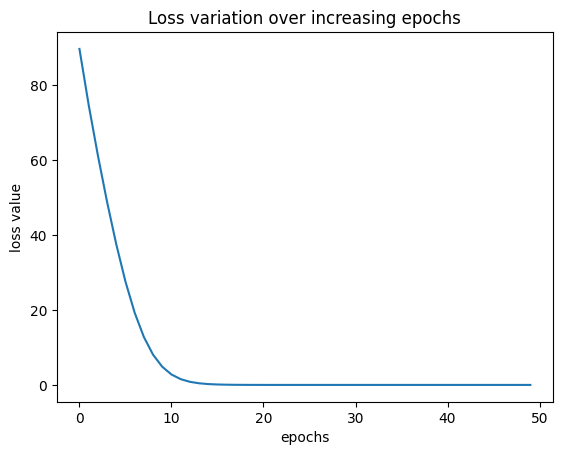

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(loss_history)
plt.title('Loss variation over increasing epochs')
plt.xlabel('epochs')
plt.ylabel('loss value')